In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# def computeMatches_SIFT(image1, image2):

In [7]:
# https://www.researchgate.net/publication/314285930_Comparison_of_Feature_Detection_and_Matching_Approaches_SIFT_and_SURF
# https://www.cs.ubc.ca/research/flann/uploads/FLANN/flann_pami2014.pdf

def computeMatches_SURF(image1, image2):
    minHessian = 400
    ratio_thresh = 0.7

    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    kp1, des1 = surf.detectAndCompute(image1, None)
    kp2, des2 = surf.detectAndCompute(image2, None)

    fl_matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    knn_matches = fl_matcher.knnMatch(des1, des2, 2)

    matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            matches.append(m)
    
    return kp1, des1, kp2, des2, matches

In [44]:
# https://en.wikipedia.org/wiki/Random_sample_consensus

def computeTrials(inNum, total_samples, num_samples, threshRatio):
    ratio = inNum / total_samples
    proportion = 1 - ratio ** num_samples
    if proportion == 0:
        return 1
    if proportion == 1:
        return np.inf
    
    return int(np.log(1-threshRatio) / np.log(proportion))
    

def ransac_affine(loc1, loc2, dist_threshold,
           max_trials=1000, threshInNum=np.inf, threshLoss=0, threshRatio=0.99):

    best_mat = None
    best_inliers = None
    bestInNum = 0
    bestResLoss = np.inf
    total_samples = loc1.shape[0]
    
    # take 3 points
    indices = np.random.choice(total_samples, 3, replace=False)

    
    for num_trials in range(max_trials):
        
        # calculate affine transformation
        src = np.array([loc1[idx] for idx in indices]).astype(np.float32)
        dst = np.array([loc2[idx] for idx in indices]).astype(np.float32)
        try:
            warp_mat = cv2.getAffineTransform(src, dst)
        except:
            continue
        
        src3d = np.append(loc1, np.ones((loc1.shape[0], 1)), axis=1)
        warp_dst3d = warp_mat @ src3d.T
        warp_dst = warp_dst3d.T
        
        # compare dst points and targets
        distance = np.linalg.norm(warp_dst - loc2, axis=1)
        inliers = distance < dist_threshold
        resLoss = np.sum(distance ** 2)
        inNum = np.count_nonzero(inliers)
        
        new_max_trials = computeTrials(inNum, total_samples, 3, threshRatio)
        
        # update transformation matrix
        if (inNum > bestInNum or (inNum == bestInNum and resLoss < bestResLoss)):
            best_mat = warp_mat
            bestInNum = inNum
            bestResLoss = resLoss
            best_inliers = inliers

        if (bestInNum > threshInNum or bestResLoss < threshLoss or num_trials > new_max_trials):
            break
        
        # resample
        indices = np.random.choice(total_samples, 3, replace=False)

    return best_mat, bestInNum/len(loc1)


In [36]:
image1 = cv2.imread('sample1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('sample2.jpg', cv2.IMREAD_GRAYSCALE)

In [37]:
kp1, des1, kp2, des2, matches = computeMatches_SURF(image1, image2)

In [38]:
num = len(matches)
loc1 = np.array([ kp1[matches[i].queryIdx].pt for i in range(num)])
loc2 = np.array([ kp2[matches[i].trainIdx].pt for i in range(num)])

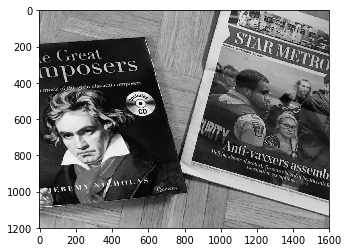

In [53]:
best_mat, _ = ransac_affine(loc1, loc2, dist_threshold=10, threshRatio=0.99)
transformed = cv2.warpAffine(image1,best_mat,(image1.shape[1], image1.shape[0]))
plt.imshow(transformed, cmap = "gray")

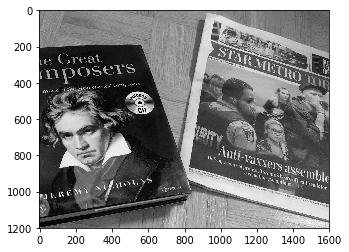

In [54]:
plt.imshow(image2, cmap="gray")

In [49]:
# https://en.wikipedia.org/wiki/Random_sample_consensus

def ransac_perspective(loc1, loc2, dist_threshold,
           max_trials=1000, threshInNum=np.inf, threshLoss=0, threshRatio=0.99):

    best_mat = None
    best_inliers = None
    bestInNum = 0
    bestResLoss = np.inf
    total_samples = loc1.shape[0]
    
    # take 3 points
    indices = np.random.choice(total_samples, 4, replace=False)

    
    for num_trials in range(max_trials):
        
        # calculate perspective transformation
        src = np.array([loc1[idx] for idx in indices]).astype(np.float32)
        dst = np.array([loc2[idx] for idx in indices]).astype(np.float32)
        try:
            warp_mat = cv2.getPerspectiveTransform(src, dst)
        except:
            continue
        
        src3d = np.append(loc1, np.ones((loc1.shape[0], 1)), axis=1)
        warp_dst3d = warp_mat @ src3d.T
        warp_dst3d[0] = np.divide(warp_dst3d[0], warp_dst3d[2])
        warp_dst3d[1] = np.divide(warp_dst3d[1], warp_dst3d[2])
        warp_dst = warp_dst3d.T[:, 0:2]
        
        # compare dst points and targets
        distance = np.linalg.norm(warp_dst - loc2, axis=1)
        inliers = distance < dist_threshold
        resLoss = np.sum(distance ** 2)
        inNum = np.count_nonzero(inliers)
        
        new_max_trials = computeTrials(inNum, total_samples, 4, threshRatio)
        
        # update transformation matrix
        if (inNum > bestInNum or (inNum == bestInNum and resLoss < bestResLoss)):
            best_mat = warp_mat
            bestInNum = inNum
            bestResLoss = resLoss
            best_inliers = inliers

        if (bestInNum > threshInNum or bestResLoss < threshLoss or num_trials > new_max_trials):
            break
        
        # resample
        indices = np.random.choice(total_samples, 3, replace=False)

    return best_mat, bestInNum/len(loc1)


In [63]:
# https://en.wikipedia.org/wiki/Random_sample_consensus

def ransac_homography(loc1, loc2, dist_threshold,
           max_trials=1000, threshInNum=np.inf, threshLoss=0, threshRatio=0.99):

    best_mat = None
    best_inliers = None
    bestInNum = 0
    bestResLoss = np.inf
    total_samples = loc1.shape[0]
    
    # take 3 points
    indices = np.random.choice(total_samples, 8, replace=False)

    
    for num_trials in range(max_trials):
        
        # calculate affine transformation
        src = np.array([loc1[idx] for idx in indices]).astype(np.float32)
        dst = np.array([loc2[idx] for idx in indices]).astype(np.float32)
        try:
            warp_mat = cv2.findHomography(src, dst)[0]
        except:
            continue
        
        src3d = np.append(loc1, np.ones((loc1.shape[0], 1)), axis=1)
        warp_dst3d = warp_mat @ src3d.T
        warp_dst3d[0] = np.divide(warp_dst3d[0], warp_dst3d[2])
        warp_dst3d[1] = np.divide(warp_dst3d[1], warp_dst3d[2])
        warp_dst = warp_dst3d.T[:, 0:2]
        
        # compare dst points and targets
        distance = np.linalg.norm(warp_dst - loc2, axis=1)
        inliers = distance < dist_threshold
        resLoss = np.sum(distance ** 2)
        inNum = np.count_nonzero(inliers)
        
        new_max_trials = computeTrials(inNum, total_samples, 8, threshRatio)
        
        # update transformation matrix
        if (inNum > bestInNum or (inNum == bestInNum and resLoss < bestResLoss)):
            best_mat = warp_mat
            bestInNum = inNum
            bestResLoss = resLoss
            best_inliers = inliers

        if (bestInNum > threshInNum or bestResLoss < threshLoss or num_trials > new_max_trials):
            break
        
        # resample
        indices = np.random.choice(total_samples, 8, replace=False)

    return best_mat, bestInNum/len(loc1)


817


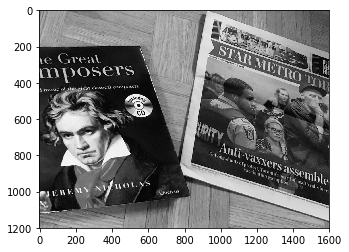

In [64]:
best_mat, _ = ransac_homography(loc1, loc2, dist_threshold=10, threshRatio=0.99)
transformed = cv2.warpPerspective(image1,best_mat,(image1.shape[1], image1.shape[0]))
plt.imshow(transformed, cmap = "gray")